In [2]:
import os
import sys
sys.path.append("../../")

from RATE_GTrXL import mem_transformer_v2_GTrXL
import os
import torch
import numpy as np
from tqdm import tqdm

from VizDoom.VizDoom_src.utils import env_vizdoom2

import matplotlib.pyplot as plt
import random
import seaborn as sns

import matplotlib.pyplot as plt
# from itertools import count
# import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(device)


libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS


device(type='cuda')

In [ ]:
from scipy.stats import sem

lst = [7.8, 4.56, 1.18]

mean = np.mean(lst)
std = np.std(lst)
_sem = sem(lst)
print(mean, std, _sem)

In [14]:
std / (3-1)**0.5

1.911171833660641

In [15]:
_sem

1.9111718336606414

In [32]:
import yaml
with open("../../VizDoom/VizDoom_src/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

config["model_mode"] = 'RATE'
config["arctitecture_mode"] = 'TrXL'
config["training_config"]["sections"] = 3

""" ARCHITECTURE MODE """
if config["arctitecture_mode"] == "TrXL":
    config["model_config"]["use_gate"] = False
    config["model_config"]["use_stable_version"] = False
elif config["arctitecture_mode"] == "TrXL-I":
    config["model_config"]["use_gate"] = False
    config["model_config"]["use_stable_version"] = True
elif config["arctitecture_mode"] == "GTrXL":
    config["model_config"]["use_gate"] = True
    config["model_config"]["use_stable_version"] = True     

print(f"Selected Architecture: {config['arctitecture_mode']}")  

""" MODEL MODE """
if config["model_mode"] == "RATE": 
    config["model_config"]["mem_len"] = 2 ########################### 2 FOR DTXL 0
    config["model_config"]["mem_at_end"] = True ########################### True FOR DTXL False
elif config["model_mode"] == "DT":
    config["model_config"]["mem_len"] = 0 ########################### 2 FOR DTXL 0
    config["model_config"]["mem_at_end"] = False ########################### True FOR DTXL False
    config["model_config"]["num_mem_tokens"] = 0
elif config["model_mode"] == "DTXL":
    config["model_config"]["mem_len"] = 2
    config["model_config"]["mem_at_end"] = False
    config["model_config"]["num_mem_tokens"] = 0
elif config["model_mode"] == "RATEM":
    config["model_config"]["mem_len"] = 0
    config["model_config"]["mem_at_end"] = True

print(f"Selected Model: {config['model_mode']}")  

Selected Architecture: TrXL
Selected Model: RATE


In [33]:
model = mem_transformer_v2_GTrXL.MemTransformerLM(**config["model_config"])

ckpt_path = f'../../VizDoom/VizDoom_checkpoints/RATE/good_z_norm_arch_mode_TrXL_RATE_RUN_1_2024_03_01_23_23_20/_4_KTD.pth'
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.to(device)
_ = model.eval()

In [42]:
env_args = {
    'simulator':'doom', 
    'scenario':'custom_scenario{:003}.cfg', #custom_scenario{:003}.cfg
    'test_scenario':'', 
    'screen_size':'320X180', 
    'screen_height':64, 
    'screen_width':112, 
    'num_environments':16,# 16
    'limit_actions':True, 
    'scenario_dir':'../../VizDoom/VizDoom_src/env/', 
    'test_scenario_dir':'', 
    'show_window':False, 
    'resize':True, 
    'multimaze':True, 
    'num_mazes_train':16, 
    'num_mazes_test':1, # 64 
    'disable_head_bob':False, 
    'use_shaping':False, 
    'fixed_scenario':False, 
    'use_pipes':False, 
    'num_actions':0, 
    'hidden_size':128, 
    'reload_model':'', 
    'model_checkpoint':'../3dcdrl/saved_models/two_col_p1_checkpoint_0198658048.pth.tar',
    'conv1_size':16, 
    'conv2_size':32, 
    'conv3_size':16, 
    'learning_rate':0.0007, 
    'momentum':0.0, 
    'gamma':0.99, 
    'frame_skip':4, 
    'train_freq':4, 
    'train_report_freq':100, 
    'max_iters':5000000, 
    'eval_freq':1000, 
    'eval_games':50, 
    'model_save_rate':1000, 
    'eps':1e-05, 
    'alpha':0.99, 
    'use_gae':False, 
    'tau':0.95, 
    'entropy_coef':0.001, 
    'value_loss_coef':0.5, 
    'max_grad_norm':0.5, 
    'num_steps':128, 
    'num_stack':1, 
    'num_frames':200000000, 
    'use_em_loss':False, 
    'skip_eval':False, 
    'stoc_evals':False, 
    'model_dir':'', 
    'out_dir':'./', 
    'log_interval':100, 
    'job_id':12345, 
    'test_name':'test_000', 
    'use_visdom':False, 
    'visdom_port':8097, 
    'visdom_ip':'http://10.0.0.1'                 
}

scene = 0
scenario = env_args['scenario_dir'] + env_args['scenario'].format(scene)
config_env = scenario

env = env_vizdoom2.DoomEnvironmentDisappear(
    scenario=config_env,
    show_window=False,
    use_info=True,
    use_shaping=False, #if False bonus reward if #shaping reward is always: +1,-1 in two_towers
    frame_skip=1,
    no_backward_movement=True)

obs = torch.tensor(env.reset()['image'])
obs.shape

seeds_list = [0,2,3,4,6,9,13,15,18,24,25,31,3,40,41,42,43,44,48,49,50,
              51,62,63,64,65,66,69,70,72,73,74,75,83,84,85,86,87,88,91,
              92,95,96,97,98,100,102,105,106,107,1,5,7,8,10,11,12,14,16,
              17,19,20,21,22,23,26,27,28,29,30,32,34,35,36,37,38,39,45,
              46,47,52,53,54,55,56,57,58,59,60,61,67,68,71,76,77,78,79,80,81,82]

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed) # it's ruine np.random.choice()
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
@torch.no_grad()
def sample(model, x, block_size, steps, sample=False, top_k=None, actions=None, rtgs=None, timestep=None, mem_tokens=1, saved_context=None):
    
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        if actions is not None:
            actions = actions if actions.size(1) <= block_size else actions[:, -block_size:] # crop context if needed
        rtgs = rtgs if rtgs.size(1) <= block_size else rtgs[:, -block_size:] # crop context if needed
        if saved_context is not None:
            results = model(x_cond, actions, rtgs,None, timestep, *saved_context, mem_tokens=mem_tokens)
        else:
            results = model(x_cond, actions, rtgs,None, timestep, mem_tokens=mem_tokens) 
            
        logits = results[0][0].detach()[:,-1,:]
        mem_tokens = results[1]
        memory = results[0][2:]
        
    return logits, mem_tokens, memory

In [43]:
# # mean and std: tensor([13.5173, 19.6073, 14.7196]) tensor([16.2992, 20.0957, 10.2147])
# mean = torch.tensor([13.5173, 19.6073, 14.7196]).to(device)
# std = torch.tensor([16.2992, 20.0957, 10.2147]).to(device)
# from VizDoom.VizDoom_src.utils import z_normalize, inverse_z_normalize

In [44]:
def get_returns_VisDoom(model, ret, seed, episode_timeout, context_length, device, act_dim, use_argmax=False, create_video=False):
    # set_seed(seed)
    
    # * USE ONLY LAST MEM TOKEN:
    use_only_last_mem_token = False
    
    # * ADD NOISE TO MEM TOKENS:
    add_noise = False

    scale = 1
    max_ep_len = episode_timeout#* 3

        
    scene = 0
    scenario = env_args['scenario_dir'] + env_args['scenario'].format(scene)
    config_env = scenario

    env = env_vizdoom2.DoomEnvironmentDisappear(
        scenario=config_env,
        show_window=False,
        use_info=True,
        use_shaping=False, #if False bonus reward if #shaping reward is always: +1,-1 in two_towers
        frame_skip=1,
        no_backward_movement=True,
        seed=seed)
    
    state = torch.tensor(env.reset()['image']).float()
    state = state.reshape(1, 1, state.shape[0], state.shape[1], state.shape[2])
   
    out_states = []
    out_states.append(state.cpu().numpy())
    done = True
    frames = []
    HISTORY_LEN = context_length
    
    rews = []
    states = state.to(device=device, dtype=torch.float32)
    actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
    rewards = torch.zeros(0, device=device, dtype=torch.float32)
    target_return = torch.tensor(ret, device=device, dtype=torch.float32).reshape(1, 1)
    timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
    episode_return, episode_length = 0, 0

    mem_tokens = model.mem_tokens.repeat(1, 1, 1).detach() if model.mem_tokens is not None else None
    saved_context = None
    segment = 0
    prompt_steps = 0# 5
    
    act_list= []
    memories = []
    
    # !!!
    if use_only_last_mem_token:
        switcher = False
        saved_mem = None
    
    for t in range(max_ep_len):
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
        rewards = torch.cat([rewards, torch.zeros(1, device=device)])
        
        if config["model_mode"] != 'DT':
            if actions.shape[0] > HISTORY_LEN:
                segment+=1
                
                if prompt_steps==0:
                    actions = actions[-1:,:]
                    states = states[:, -1:, :, :, :]
                    #target_return = target_return[:,-1:]
                    target_return = torch.tensor(ret, device=device, dtype=torch.float32).reshape(1, 1)
                    timesteps = timesteps[:, -1:]
                else:
                    actions = actions[-prompt_steps:,:]
                    states = states[:, -prompt_steps:, :, :, :]
                    target_return = target_return[:,-prompt_steps:]#+3600.
                    timesteps = timesteps[:, -prompt_steps:]
                    
                if t%(context_length)==0 and t>5:
                    # !!!
                    if use_only_last_mem_token:
                        mem_tokens = saved_mem
                    else:
                        mem_tokens = new_mem
                    
                    saved_context = new_notes
                    
                    if create_video:
                        out = torch.norm(mem_tokens).item() if mem_tokens is not None else None
                        print(f't: {t}, NEW MEMORY: {out}')
                    
        else:
            if actions.shape[0] > HISTORY_LEN:
                segment+=1
                
                if prompt_steps==0:
                    actions = actions[1:,:]
                    states = states[:, 1:, :, :, :]
                    target_return = target_return[:,1:]
                    timesteps = timesteps[:, 1:]
                else:
                    actions = actions[-prompt_steps:,:]
                    states = states[:, -prompt_steps:, :, :, :]
                    target_return = target_return[:,-prompt_steps:]#+3600.
                    timesteps = timesteps[:, -prompt_steps:]
                    
                if t%(context_length)==0 and t>5:
                    if create_video:
                        out = torch.norm(mem_tokens).item() if mem_tokens is not None else None
                        print(f't: {t}, NEW MEMORY: {out}')
                    mem_tokens = new_mem
                    saved_context = new_notes

        #print(states.shape,actions.shape,target_return.shape,timesteps.shape)
        if t==0:
            act_to_pass = None
        else:
            act_to_pass = actions.unsqueeze(0)[:, 1:, :]
            if act_to_pass.shape[1] == 0:
                act_to_pass = None 
        
        #print(states.shape, target_return.shape, act_to_pass.shape if act_to_pass is not None else act_to_pass)
        # print(t, timesteps[:, -1])
        
        if add_noise:
            added_noise = torch.randn_like(mem_tokens)
        else:
            added_noise = torch.zeros_like(mem_tokens)
        
        # !!!!!!!!!!!!!!!!!!!!!!!!!
        
        # print(states.mean(), states.std())
        # plt.imshow(states[0][0].cpu().permute(1,2,0)/255)
        # plt.show()
        b, l, c, h, w = states.shape
        states_norm = states.reshape(b*l, c, h, w)
        states_norm = z_normalize(states_norm, mean, std)
        states_norm = states_norm.reshape(b, l, c, h, w).to(device)
        # print(states_norm.mean(), states_norm.std())
        # plt.imshow(states_norm[0][0].cpu().permute(1,2,0))
        # plt.show()

        # !!!!!!!!!!!!!!!!!!!
        try:
            sampled_action, new_mem, new_notes = sample(model=model,  
                                                        x=states_norm,
                                                        block_size=HISTORY_LEN, 
                                                        steps=1, 
                                                        sample=True, 
                                                        actions=act_to_pass, 
                                                        rtgs=target_return.unsqueeze(-1), 
                                                        timestep=timesteps, 
                                                        mem_tokens=mem_tokens,#torch.randn_like(mem_tokens),#mem_tokens+added_noise, 
                                                        saved_context=saved_context)
        except:
            print("ERROR!!!!!!!!!!!", t, states.shape, target_return.shape, act_to_pass.shape)
            
        # !!!!!!!
        if use_only_last_mem_token:
            if t > 0 and t % (context_length-1) == 0 and switcher == False:
                switcher = True
                saved_mem = new_mem
            
        if new_mem is not None:
            memories.append(mem_tokens.detach().cpu().numpy())
        #print(sampled_action[-1])
        
        # print(np.round(torch.softmax(sampled_action, dim=-1).squeeze().detach().cpu().numpy(), 3))
        if use_argmax == False:
            act = np.random.choice([0, 1, 2, 3, 4], p=torch.softmax(sampled_action, dim=-1).squeeze().detach().cpu().numpy())
        
        actions[-1] = act
        act_list.append(act)
        
        state, reward, done, info = env.step(act)
        #print(t, reward)
        state = np.float32(state['image'])
        state = state.reshape(1, 1, state.shape[0], state.shape[1], state.shape[2])
        
        out_states.append(state)
        
        rews.append(reward)
        #print(reward)
        cur_state = torch.from_numpy(state).to(device=device).float()
        states = torch.cat([states, cur_state], dim=1)
        rewards[-1] = reward
        pred_return = target_return[0,-1] - (reward/scale)
        target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
        # timesteps = torch.cat([timesteps,torch.ones((1, 1), device=device, dtype=torch.long) * (t+1)], dim=1)
        timesteps = torch.cat([timesteps,torch.ones((1, 1), device=device, dtype=torch.long) * (1)], dim=1)
        episode_return += reward
        episode_length += 1
        
        if done:
            torch.cuda.empty_cache()
            break  
        
    if create_video == True:
        print("\n")
    
    env.close()
    return episode_return, act_list, t, out_states, memories

# * ##############################################

episode_timeout = 2100
use_argmax = False
episode_return, act_list1, t, states1, memories = get_returns_VisDoom(model=model, ret=56.5, seed=2, 
                                                                      episode_timeout=episode_timeout, 
                                                                      context_length=config["training_config"]["context_length"], 
                                                                      device=device, 
                                                                      act_dim=config["model_config"]["ACTION_DIM"], 
                                                                      use_argmax=use_argmax, create_video=True)

print("Episode return:", episode_return)

t: 30, NEW MEMORY: 24.774707794189453
t: 60, NEW MEMORY: 25.12302589416504
t: 90, NEW MEMORY: 25.22589874267578
t: 120, NEW MEMORY: 25.16219139099121
t: 150, NEW MEMORY: 25.181629180908203
t: 180, NEW MEMORY: 25.177223205566406
t: 210, NEW MEMORY: 25.158123016357422
t: 240, NEW MEMORY: 25.274267196655273
t: 270, NEW MEMORY: 25.26866340637207
t: 300, NEW MEMORY: 25.23937225341797
t: 330, NEW MEMORY: 25.297454833984375
t: 360, NEW MEMORY: 25.271345138549805
t: 390, NEW MEMORY: 25.24715805053711
t: 420, NEW MEMORY: 25.198091506958008
t: 450, NEW MEMORY: 25.23413848876953
t: 480, NEW MEMORY: 25.23448944091797
t: 510, NEW MEMORY: 25.234237670898438
t: 540, NEW MEMORY: 25.184797286987305
t: 570, NEW MEMORY: 25.137937545776367
t: 600, NEW MEMORY: 25.213516235351562
t: 630, NEW MEMORY: 25.190441131591797
t: 660, NEW MEMORY: 25.244243621826172
t: 690, NEW MEMORY: 25.275060653686523
t: 720, NEW MEMORY: 25.18689727783203
t: 750, NEW MEMORY: 25.12855339050293
t: 780, NEW MEMORY: 25.102115631103516

In [29]:
# observations = [np.squeeze(o).transpose(1,2,0)*255 for o in states1]
# clip = ImageSequenceClip(observations, fps=15)
# clip.write_videofile(f'../model_evaluation/fixed/like_atari_wo_erl_stop_RMDT_RUN_1_2024_01_29_21_23_02/validation_1_t_{t}.mp4')

RET: 1.01


Time: 575, Return: 12.76: 100%|██████████| 100/100 [07:00<00:00,  4.21s/it]


Mean reward: 10.49
STD reward: 5.58
Mean T: 518.34
STD T: 213.80


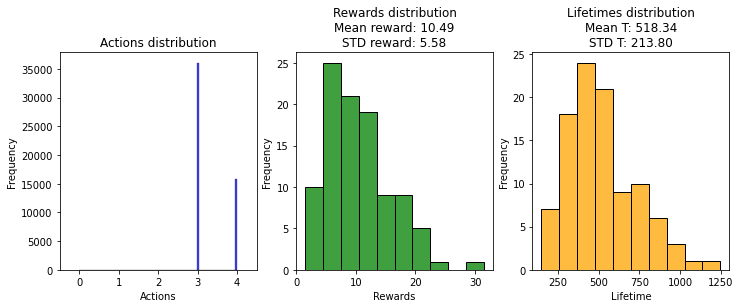

RET: 3.9


Time: 306, Return: 5.07: 100%|██████████| 100/100 [06:40<00:00,  4.00s/it] 


Mean reward: 9.66
STD reward: 5.35
Mean T: 489.97
STD T: 216.91


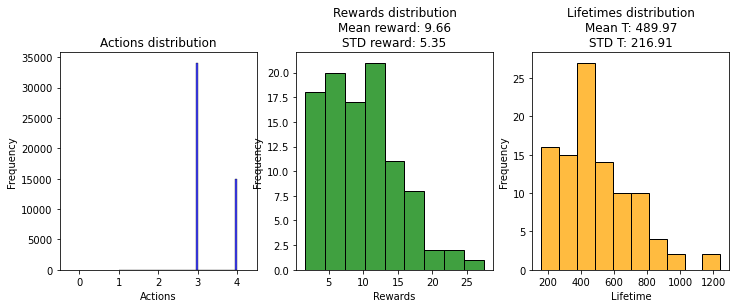

RET: 11.1


Time: 319, Return: 5.20: 100%|██████████| 100/100 [06:50<00:00,  4.10s/it] 


Mean reward: 9.85
STD reward: 5.81
Mean T: 503.41
STD T: 232.70


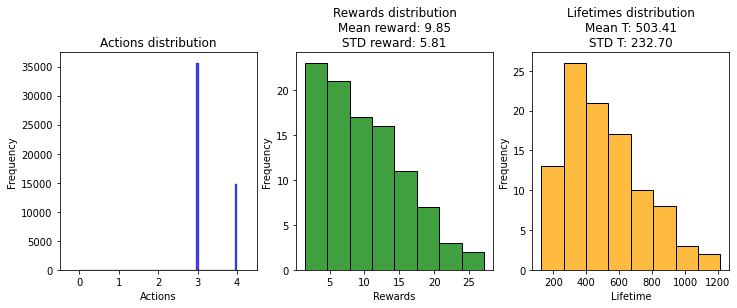

RET: 56.5


Time: 319, Return: 5.20: 100%|██████████| 100/100 [06:05<00:00,  3.65s/it] 


Mean reward: 9.42
STD reward: 5.90
Mean T: 490.88
STD T: 237.20


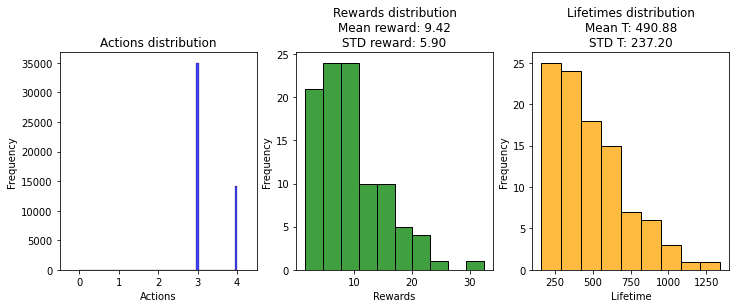

In [30]:
for ret in [1.01, 3.9, 11.1, 56.5]:
    print("RET:", ret)
    goods, bads = 0, 0
    acts = []

    seeds_list = [0,2,3,4,6,9,13,15,18,24,25,31,3,40,41,42,43,44,48,49,50,
                51,62,63,64,65,66,69,70,72,73,74,75,83,84,85,86,87,88,91,
                92,95,96,97,98,100,102,105,106,107,1,5,7,8,10,11,12,14,16,
                17,19,20,21,22,23,26,27,28,29,30,32,34,35,36,37,38,39,45,
                46,47,52,53,54,55,56,57,58,59,60,61,67,68,71,76,77,78,79,80,81,82]

    # seeds_list = [0,2,3,4,6,9,13,15,18,24,25,31,3,40,41,42,43,44,48,49,50]

    seeds = seeds_list # np.arange(1, 101).tolist()
    pbar = tqdm(range(len(seeds)))
    returns = []
    ts = []
    for i in pbar:
        episode_return, act_list, t, _, _ = get_returns_VisDoom(model=model, ret=ret, seed=seeds[i], episode_timeout=episode_timeout, context_length=config["training_config"]["context_length"], 
                                                            device=device, act_dim=config["model_config"]["ACTION_DIM"], use_argmax=use_argmax, create_video=False)
        acts += act_list
        returns.append(episode_return)
        ts.append(t)
        pbar.set_description(f"Time: {t}, Return: {episode_return:.2f}")
        
    print(f"Mean reward: {np.mean(returns):.2f}")
    print(f"STD reward: {np.std(returns):.2f}")
    print(f"Mean T: {np.mean(ts):.2f}")
    print(f"STD T: {np.std(ts):.2f}")

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(acts, ax=axs[0], color='blue')
    axs[0].set_title('Actions distribution')
    axs[0].set_xlabel('Actions')
    axs[0].set_ylabel('Frequency')
    axs[0].set_xlim([-0.5, 4.5])

    sns.histplot(returns, ax=axs[1], color='green')
    axs[1].set_title(f'Rewards distribution\nMean reward: {np.mean(returns):.2f}\nSTD reward: {np.std(returns):.2f}')
    axs[1].set_xlabel('Rewards')
    axs[1].set_ylabel('Frequency')

    sns.histplot(ts, ax=axs[2], color='orange')
    axs[2].set_title(f'Lifetimes distribution\nMean T: {np.mean(ts):.2f}\nSTD T: {np.std(ts):.2f}')
    axs[2].set_xlabel('Lifetime')
    axs[2].set_ylabel('Frequency')

    plt.show()

RET: 1.01


Time: 191, Return: 1.92: 100%|██████████| 100/100 [06:43<00:00,  4.03s/it] 


Mean reward: 9.72
STD reward: 5.48
Mean T: 498.48
STD T: 218.16


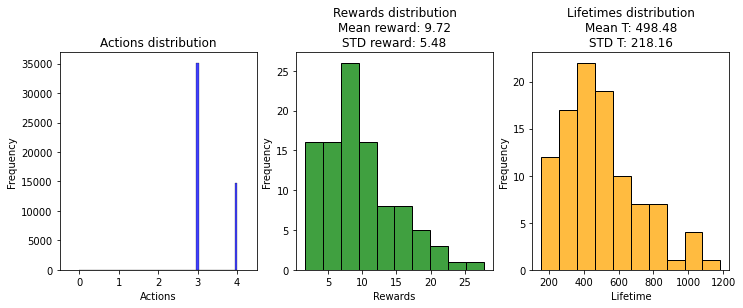

RET: 3.9


Time: 191, Return: 1.92: 100%|██████████| 100/100 [06:49<00:00,  4.09s/it] 


Mean reward: 9.82
STD reward: 5.92
Mean T: 501.04
STD T: 223.46


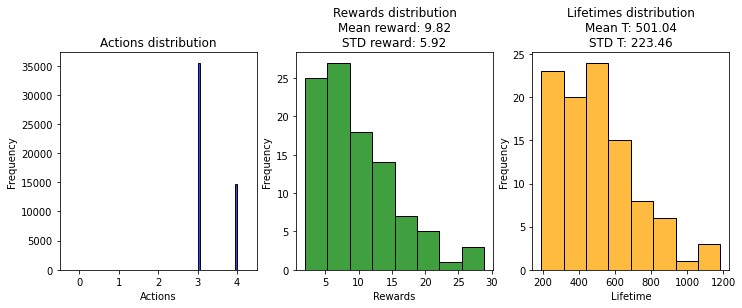

RET: 11.1


Time: 191, Return: 1.92: 100%|██████████| 100/100 [06:48<00:00,  4.08s/it] 


Mean reward: 9.87
STD reward: 5.55
Mean T: 503.72
STD T: 216.81


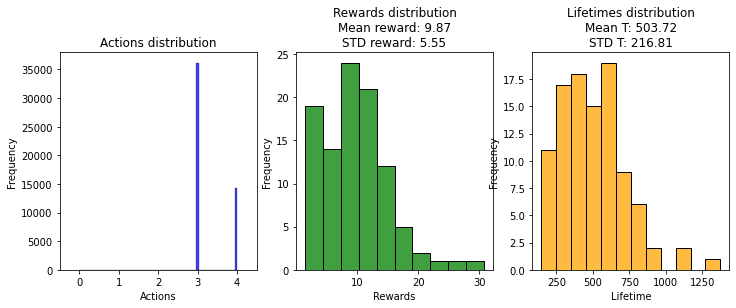

RET: 56.5


Time: 191, Return: 1.92: 100%|██████████| 100/100 [06:47<00:00,  4.08s/it] 


Mean reward: 10.31
STD reward: 6.63
Mean T: 532.97
STD T: 272.66


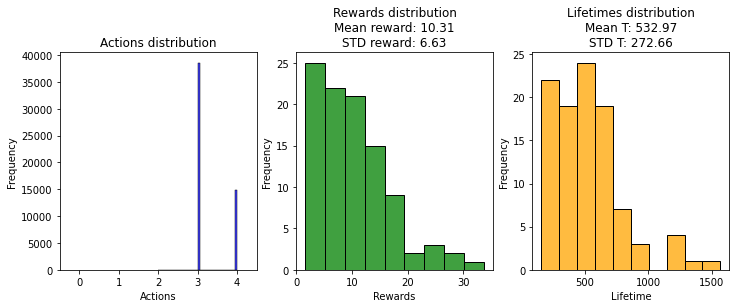

In [22]:
for ret in [1.01, 3.9, 11.1, 56.5]:
    print("RET:", ret)
    goods, bads = 0, 0
    acts = []

    seeds_list = [0,2,3,4,6,9,13,15,18,24,25,31,3,40,41,42,43,44,48,49,50,
                51,62,63,64,65,66,69,70,72,73,74,75,83,84,85,86,87,88,91,
                92,95,96,97,98,100,102,105,106,107,1,5,7,8,10,11,12,14,16,
                17,19,20,21,22,23,26,27,28,29,30,32,34,35,36,37,38,39,45,
                46,47,52,53,54,55,56,57,58,59,60,61,67,68,71,76,77,78,79,80,81,82]

    # seeds_list = [0,2,3,4,6,9,13,15,18,24,25,31,3,40,41,42,43,44,48,49,50]

    seeds = seeds_list # np.arange(1, 101).tolist()
    pbar = tqdm(range(len(seeds)))
    returns = []
    ts = []
    for i in pbar:
        episode_return, act_list, t, _, _ = get_returns_VisDoom(model=model, ret=ret, seed=seeds[i], episode_timeout=episode_timeout, context_length=config["training_config"]["context_length"], 
                                                            device=device, act_dim=config["model_config"]["ACTION_DIM"], use_argmax=use_argmax, create_video=False)
        acts += act_list
        returns.append(episode_return)
        ts.append(t)
        pbar.set_description(f"Time: {t}, Return: {episode_return:.2f}")
        
    print(f"Mean reward: {np.mean(returns):.2f}")
    print(f"STD reward: {np.std(returns):.2f}")
    print(f"Mean T: {np.mean(ts):.2f}")
    print(f"STD T: {np.std(ts):.2f}")

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(acts, ax=axs[0], color='blue')
    axs[0].set_title('Actions distribution')
    axs[0].set_xlabel('Actions')
    axs[0].set_ylabel('Frequency')
    axs[0].set_xlim([-0.5, 4.5])

    sns.histplot(returns, ax=axs[1], color='green')
    axs[1].set_title(f'Rewards distribution\nMean reward: {np.mean(returns):.2f}\nSTD reward: {np.std(returns):.2f}')
    axs[1].set_xlabel('Rewards')
    axs[1].set_ylabel('Frequency')

    sns.histplot(ts, ax=axs[2], color='orange')
    axs[2].set_title(f'Lifetimes distribution\nMean T: {np.mean(ts):.2f}\nSTD T: {np.std(ts):.2f}')
    axs[2].set_xlabel('Lifetime')
    axs[2].set_ylabel('Frequency')

    plt.show()

In [24]:
10/7*100

142.85714285714286

RET: 1.01


Time: 511, Return: 9.12: 100%|██████████| 100/100 [07:01<00:00,  4.21s/it] 


Mean reward: 6.42
STD reward: 3.65
Mean T: 451.62
STD T: 166.75


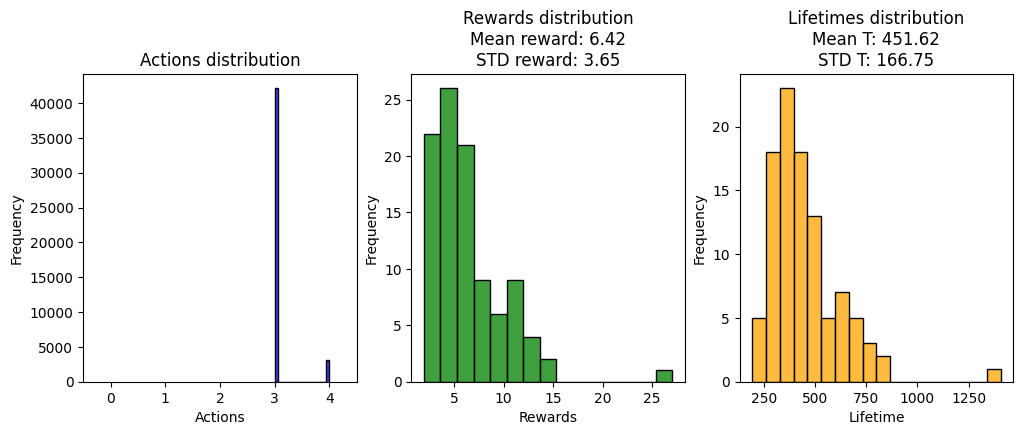

RET: 3.9


Time: 415, Return: 7.16: 100%|██████████| 100/100 [06:03<00:00,  3.64s/it] 


Mean reward: 5.79
STD reward: 2.92
Mean T: 426.32
STD T: 139.56


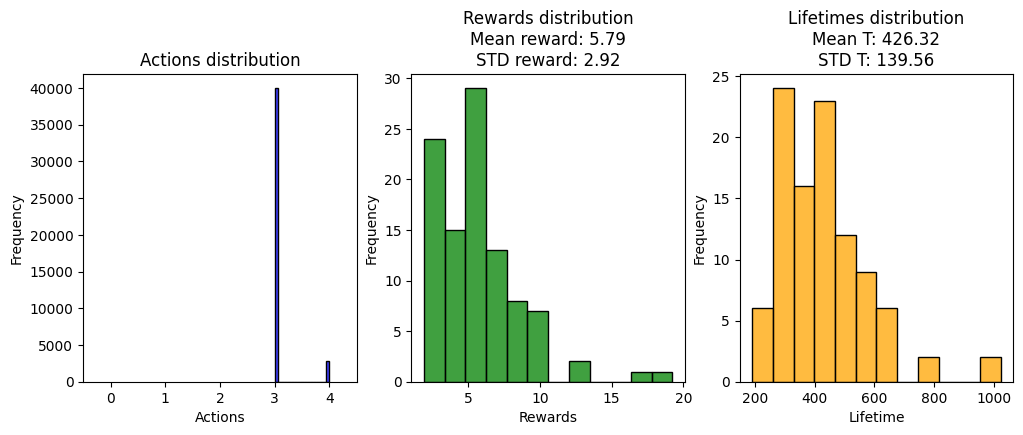

RET: 11.1


Time: 554, Return: 8.55: 100%|██████████| 100/100 [06:17<00:00,  3.78s/it]


Mean reward: 5.99
STD reward: 2.70
Mean T: 443.34
STD T: 125.80


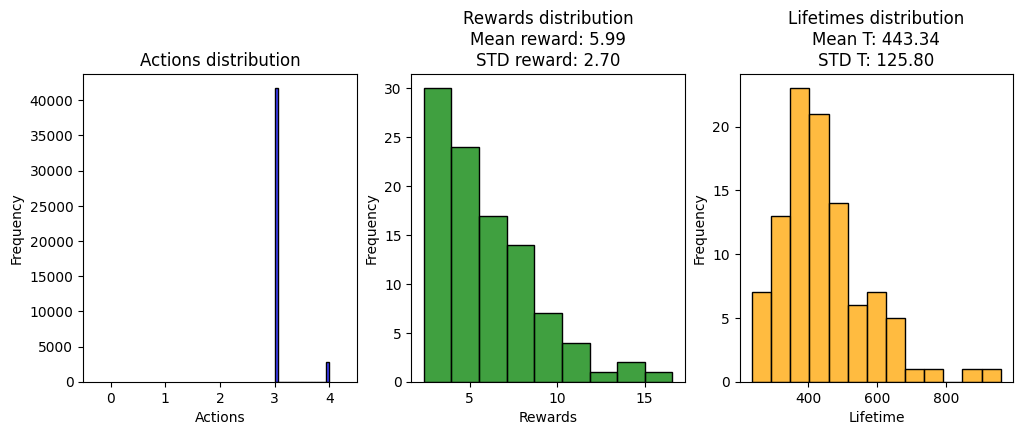

RET: 56.5


Time: 603, Return: 10.04: 100%|██████████| 100/100 [06:07<00:00,  3.67s/it]


Mean reward: 5.64
STD reward: 2.46
Mean T: 423.11
STD T: 120.42


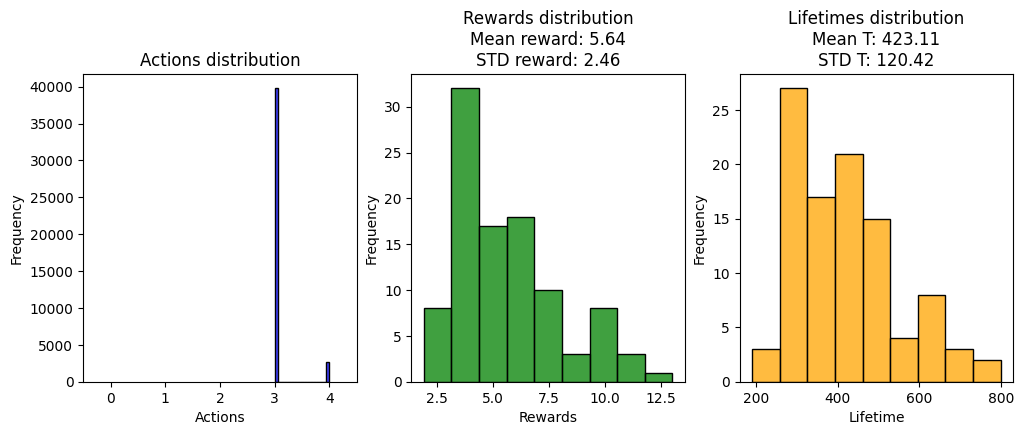

In [14]:
for ret in [1.01, 3.9, 11.1, 56.5]:
    print("RET:", ret)
    goods, bads = 0, 0
    acts = []

    seeds_list = [0,2,3,4,6,9,13,15,18,24,25,31,3,40,41,42,43,44,48,49,50,
                51,62,63,64,65,66,69,70,72,73,74,75,83,84,85,86,87,88,91,
                92,95,96,97,98,100,102,105,106,107,1,5,7,8,10,11,12,14,16,
                17,19,20,21,22,23,26,27,28,29,30,32,34,35,36,37,38,39,45,
                46,47,52,53,54,55,56,57,58,59,60,61,67,68,71,76,77,78,79,80,81,82]

    # seeds_list = [0,2,3,4,6,9,13,15,18,24,25,31,3,40,41,42,43,44,48,49,50]

    seeds = seeds_list # np.arange(1, 101).tolist()
    pbar = tqdm(range(len(seeds)))
    returns = []
    ts = []
    for i in pbar:
        episode_return, act_list, t, _, _ = get_returns_VisDoom(model=model, ret=ret, seed=seeds[i], episode_timeout=episode_timeout, context_length=context_length, 
                                                            device=device, act_dim=act_dim, use_argmax=use_argmax, create_video=False)
        acts += act_list
        returns.append(episode_return)
        ts.append(t)
        pbar.set_description(f"Time: {t}, Return: {episode_return:.2f}")
        
    print(f"Mean reward: {np.mean(returns):.2f}")
    print(f"STD reward: {np.std(returns):.2f}")
    print(f"Mean T: {np.mean(ts):.2f}")
    print(f"STD T: {np.std(ts):.2f}")

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(acts, ax=axs[0], color='blue')
    axs[0].set_title('Actions distribution')
    axs[0].set_xlabel('Actions')
    axs[0].set_ylabel('Frequency')
    axs[0].set_xlim([-0.5, 4.5])

    sns.histplot(returns, ax=axs[1], color='green')
    axs[1].set_title(f'Rewards distribution\nMean reward: {np.mean(returns):.2f}\nSTD reward: {np.std(returns):.2f}')
    axs[1].set_xlabel('Rewards')
    axs[1].set_ylabel('Frequency')

    sns.histplot(ts, ax=axs[2], color='orange')
    axs[2].set_title(f'Lifetimes distribution\nMean T: {np.mean(ts):.2f}\nSTD T: {np.std(ts):.2f}')
    axs[2].set_xlabel('Lifetime')
    axs[2].set_ylabel('Frequency')

    plt.show()

In [ ]:
from colabgymrender.recorder import Recorder
@torch.no_grad()
def sample(model, x, block_size, steps, temperature=1.0, sample=False, top_k=None, actions=None, rtgs=None, timestep=None, mem_tokens=1, saved_context=None):
    
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        if actions is not None:
            actions = actions if actions.size(1) <= block_size else actions[:, -block_size:] # crop context if needed
        rtgs = rtgs if rtgs.size(1) <= block_size else rtgs[:, -block_size:] # crop context if needed
        if saved_context is not None:
            results = model(x_cond, actions, rtgs,None, timestep, *saved_context, mem_tokens=mem_tokens)
        else:
            results = model(x_cond, actions, rtgs,None, timestep, mem_tokens=mem_tokens) 
            
        logits = results[0][0].detach()[:,-1,:]
        mem_tokens = results[1]
        memory = results[0][2:]
        
    return logits, mem_tokens, memory

def get_returns(env, ret, use_recorder=False, return_frames=False, prompt_steps=5, memory_20step=True, without_memory=False):
    
    ret = ret/scale


    done = True
    frames = []
    HISTORY_LEN = context_length
    state = env.reset(); rews = []
    states = torch.from_numpy(state).reshape(1, state_dim).to(device=device, dtype=torch.float32)
    actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
    rewards = torch.zeros(0, device=device, dtype=torch.float32)
    target_return = torch.tensor(ret, device=device, dtype=torch.float32).reshape(1, 1)
    timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
    sim_states = []
    episode_return, episode_length = 0, 0

    mem_tokens = model.mem_tokens.repeat(1, 1, 1).detach()
    saved_context = None
    segment = 0

    for t in range(max_ep_len):

        #actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
        #rewards = torch.cat([rewards, torch.zeros(1, device=device)])

        act_new_segment = False
        if actions.shape[0] > HISTORY_LEN -1:
            segment+=1
            
            if prompt_steps==0:
                states = torch.from_numpy(state).reshape(1, state_dim).to(device=device, dtype=torch.float32)
                actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
                target_return = torch.tensor(ret, device=device, dtype=torch.float32).reshape(1, 1)
                timesteps = timesteps[:, -1:]
                act_new_segment = True
            else:
                actions = actions[-prompt_steps:,:]
                states = states[-prompt_steps:, :]
                target_return = target_return[:,-prompt_steps:]#+3600.
                timesteps = timesteps[:, -prompt_steps:]
                
            if not without_memory:
                if memory_20step:
                    if t%20==0 and t>5:
                        mem_tokens = new_mem
                        saved_context = new_notes
                else:
                    mem_tokens = new_mem
                    saved_context = new_notes
 
        if t==0 or act_new_segment:
            act_to_pass = None
        else:
            act_to_pass = actions.unsqueeze(0)[:,:,:] # :,1: for original
            if act_to_pass.shape[1]==0:
                act_to_pass = None       
                
        sampled_action, new_mem, new_notes = sample(model=model,  
                                                    x=(states.unsqueeze(0)- state_mean_torch) / state_std_torch,
                                                    block_size=HISTORY_LEN, 
                                                    steps=1, 
                                                    temperature=1.0, 
                                                    sample=True, 
                                                    actions=act_to_pass, 
                                                    rtgs=target_return.unsqueeze(-1), 
                        timestep=timesteps, 
                        mem_tokens=mem_tokens, 
                        saved_context=saved_context) 

        #actions[-1] = sampled_action
        actions = torch.cat([actions, sampled_action])

        action = sampled_action.cpu().numpy()[0]
        state, reward, done, _ = env.step(action)
        rews.append(reward)
        cur_state = torch.from_numpy(state).to(device=device).reshape(1, state_dim).float()
        states = torch.cat([states, cur_state], dim=0)
        rewards = torch.cat([rewards, torch.from_numpy(np.array([reward])).to(device)])
        pred_return = target_return[0,-1] #- (reward/scale)
        target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
        timesteps = torch.cat([timesteps,torch.ones((1, 1), device=device, dtype=torch.long) * (t+1)], dim=1)
        episode_return += reward
        episode_length += 1

        if done:
            break  
    
    episode_return = env.get_normalized_score(episode_return)*100.
    
    #eval_return = sum(T_rewards)/float(N)
    #print("target return: %d, eval return: %d" % (ret, episode_return))
    
    return episode_return, env